In [1]:
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import seaborn as sns

%matplotlib inline
sns.set()

### Dataset
MNIST handwritten digits, reshaped to vectors in $\mathbb{R}^{784}$, and binarized.

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape((x_train.shape[0], -1)) / 255
x_train = np.where(x_train < 0.5, 0, 1).astype('float32')
x_test  = x_test.reshape((x_test.shape[0], -1)) / 255
x_test = np.where(x_test < 0.5, 0, 1).astype('float32')

## Variational Autoencoder

#### Encoder
The encoder takes an input $x$, and compresses it down to a lower dimensonal latent vector $z$. Actually, it is stochastic so it outputs parameters $\theta = \{\mu, \sigma\}$ to $q_{\theta}(z|x)$ which is an isotropic multivariate Gaussian distribution $\mathcal{N}(\mu, \sigma I)$. When we sample from this distribution we get noisy representations of $z$.

#### Decoder
The decoder takes a latent vector $z$ and outputs parameters for the data distributions that we can sample from to generate a sample. In this case of binarized, flattened MNIST images, the output is 784 Bernoulli parameters $p_{\phi}(x|z) = \{ \mu_1, \dots, \mu_{784} \}$.


#### Variational Autoencoder
The full variational autoencoder has an encoder and a decoder. It takes a batch of input images in and outputs a batch of parameters $\mu, \sigma, p$ to be used to calculate the loss. $z$ is sampled using the reparameterization trick by letting $z=\mu + \sigma \epsilon$, where $\epsilon \sim \mathcal{N}(0, 1)$, to make $z$ deterministic with respect to the parameters, allowing gradients to be computed. Since the KL-diveregence regularizer pushes the parameters of the encoder toward a unit gaussian, we can then hallucinate MNIST digits by sampling from a unit gaussian (of the hidden dimension) and feeding these vectors through the decoder!

In [3]:
class Encoder(tf.keras.layers.Layer):
    """ Gaussian distribution q(z|x) of dimension hidden_dim """
    def __init__(self, hidden_dim):
        super().__init__()
        self.h = hidden_dim
        self.dense1 = tf.keras.layers.Dense(2 * hidden_dim, activation='relu')
        self.dense2 = tf.keras.layers.Dense(2 * hidden_dim)
    
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        mean, std = x[:, :self.h], tf.nn.softplus(x[:, self.h:])
        return mean, std
        
    
class Decoder(tf.keras.layers.Layer):
    """ Bernoulli distribution p(x|z) of dimension output_dim """
    def __init__(self, hidden_dim, output_dim=784):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(2 * hidden_dim, activation='relu')
        self.dense2 = tf.keras.layers.Dense(output_dim, activation='sigmoid')
    
    def call(self, z):
        z = self.dense1(z)
        p = self.dense2(z)
        return p
        
    
class VAE(tf.keras.Model):
    
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.encoder = Encoder(hidden_dim)
        self.decoder = Decoder(hidden_dim)
        
    def call(self, x):
        mean, std = self.encoder(x)
        eps = tf.random.normal(shape=mean.shape)
        z = mean + std * eps  # Reparametrization trick, so that z is deterministic wrp. mean & std. to allow gra
        p = self.decoder(z)
        return mean, std, p
    
    def hallucinate(self, n):
        z = tf.random.normal(shape=(n, self.hidden_dim))
        p = self.decoder(z)
        return p.numpy().reshape(n, 28, 28)

### Loss Function
Implementing the loss functions, the reconstruction loss is a single sample Monte-Carlo estimate and the KL-divergence loss is the analytical solution between two Gaussians. One is the unit Gaussian, and the other is the distribution output by the encoder.

In [4]:
def log(x):
    """ Dodging nans """
    eps = 1e-8
    return tf.math.log(x + eps)


def reconstruction_loss(x, p):
    return -tf.einsum("ij, ij -> i", x, log(p)) - tf.einsum("ij, ij ->i", (1 - x), log(1 - p))


def kldiv_loss(mean, std):
    return tf.reduce_sum((tf.square(std) + tf.square(mean) - 1) / 2 - log(std), axis=-1)


def compute_loss(model, x):
    mean, std, p = model(x)
    rec_loss = reconstruction_loss(x, p)
    kld_loss = kldiv_loss(mean, std)
    return tf.reduce_mean(rec_loss + kld_loss)

### Helper Functions
Just some helper functions to make the training loop a bit more readable!

In [5]:
train_loss = tf.keras.metrics.Mean(name='training loss')
test_loss  = tf.keras.metrics.Mean(name='test loss')

def train_step(model, x):
    with tf.GradientTape() as tape:
            loss = compute_loss(model, x)
    
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))

    train_loss(loss)

    
def test_step(model, x):
    loss = compute_loss(model, x)
    test_loss(loss)

    
def reset_metrics():
    train_loss.reset_states()
    test_loss.reset_states()

    
def write_to_tensorboard(epoch):
    tf.summary.scalar(name='training loss', data=train_loss.result(), step=epoch)
    tf.summary.scalar(name='test loss', data=test_loss.result(), step=epoch)

    
def hallucinate_images(model, N=5, save=False):
    """ Show N * N hallucinated images in a grid """
    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111, nrows_ncols=(N, N), axes_pad=0.1)
    images = model.hallucinate(int(N * N))

    for ax, im in zip(grid, images):
        ax.imshow(im)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.grid(False)

    plt.axis('off')
    if save:
        plt.savefig("hallucinated.png", dpi=500)
    plt.show()

[  0,   0] ---> Train loss: 555.51
[  0, 100] ---> Train loss: 490.17
[  0, 200] ---> Train loss: 397.93
[  0, 300] ---> Train loss: 350.14
[  0, 400] ---> Train loss: 321.75
After epoch 0:
Test loss : 225.74



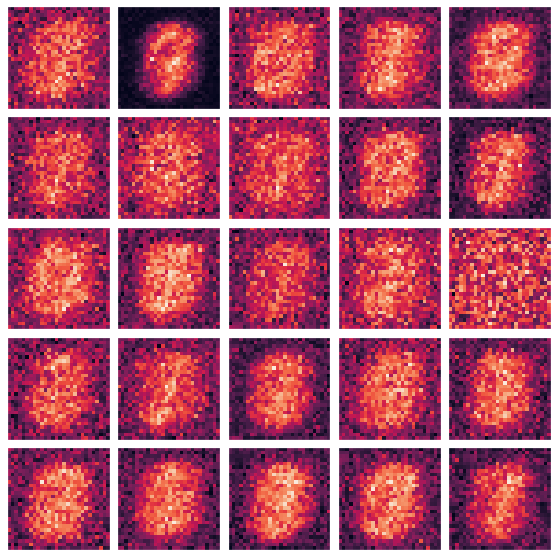

[  1,   0] ---> Train loss: 224.36
[  1, 100] ---> Train loss: 223.00
[  1, 200] ---> Train loss: 219.59
[  1, 300] ---> Train loss: 216.42
[  1, 400] ---> Train loss: 213.70
After epoch 1:
Test loss : 199.20

[  2,   0] ---> Train loss: 206.05
[  2, 100] ---> Train loss: 197.61
[  2, 200] ---> Train loss: 195.20
[  2, 300] ---> Train loss: 192.97
[  2, 400] ---> Train loss: 190.86
After epoch 2:
Test loss : 179.05

[  3,   0] ---> Train loss: 177.31
[  3, 100] ---> Train loss: 178.13
[  3, 200] ---> Train loss: 176.87
[  3, 300] ---> Train loss: 175.78
[  3, 400] ---> Train loss: 174.61
After epoch 3:
Test loss : 168.11

[  4,   0] ---> Train loss: 165.36
[  4, 100] ---> Train loss: 168.27
[  4, 200] ---> Train loss: 167.31
[  4, 300] ---> Train loss: 166.57
[  4, 400] ---> Train loss: 165.82
After epoch 4:
Test loss : 160.78

[  5,   0] ---> Train loss: 156.98
[  5, 100] ---> Train loss: 160.42
[  5, 200] ---> Train loss: 160.20
[  5, 300] ---> Train loss: 159.71
[  5, 400] ---> Trai

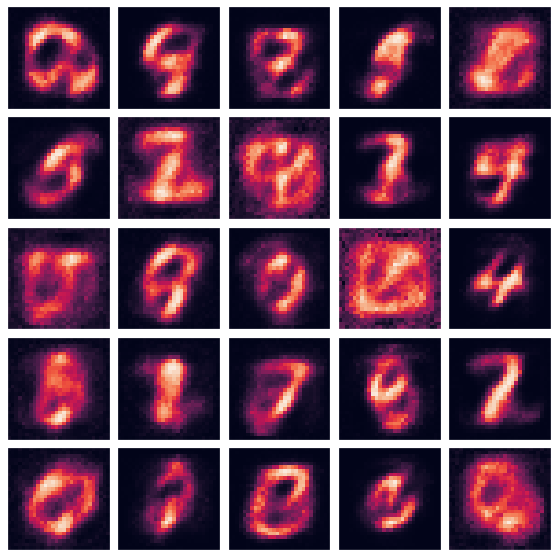

[ 11,   0] ---> Train loss: 141.78
[ 11, 100] ---> Train loss: 138.92
[ 11, 200] ---> Train loss: 138.89
[ 11, 300] ---> Train loss: 138.66
[ 11, 400] ---> Train loss: 138.49
After epoch 11:
Test loss : 135.96

[ 12,   0] ---> Train loss: 138.05
[ 12, 100] ---> Train loss: 136.04
[ 12, 200] ---> Train loss: 136.18


In [ ]:
EPOCHS = 25
LATENT = 50

bs = 128
test_ds = tf.data.Dataset.from_tensor_slices(x_test).batch(bs)
train_ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(bs)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/VAE/' + current_time
writer = tf.summary.create_file_writer(log_dir)

tmp_train = "[{:3d}, {:3d}] ---> Train loss: {:3.2f}"
tmp_test = "Test loss : {:3.2f}\n"

model = VAE(hidden_dim=LATENT)
opt = tf.keras.optimizers.Adam(1e-4)

reset_metrics()
with writer.as_default():
    
    for epoch in range(EPOCHS):

        for i, x_tr in enumerate(train_ds):
            train_step(model, x_tr)
            if i % 100 == 0:
                print(tmp_train.format(epoch, i, train_loss.result()))

        for x_te in test_ds:
            test_step(model, x_te)
        
        print(f"After epoch {epoch}:")
        print(tmp_test.format(test_loss.result()))
        
        # Visualize some hallucinated images every 10th epoch to see the progress!
        if epoch % 10 == 0:
            hallucinate_images(model, 5)
            
        write_to_tensorboard(epoch)
        reset_metrics()

In [ ]:
hallucinate_images(model, 10)